In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:
data = pd.read_csv('Data/player_stats_cleaned.csv')
data.head()

,id,name,dateOfBirth,Age,Height,Foot,Position,OtherPosition,National,MarketValue,...,25A,25MP,25AP,Ranking,2020AvgMV,2021AvgMV,2022AvgMV,2023AvgMV,2024AvgMV,TotalCups
0,591949,Aaron Hickey,"Jun 10, 2002",22,1.85,both,Right-Back,"['Left-Back', 'Left Midfield']",Scotland,22000000.0,...,0,0.0,0,432.000,1.845000e+06,8.666667e+06,17000000.0,2.833333e+07,2.500000e+07,0
1,434207,Aaron Connolly,"Jan 28, 2000",25,1.74,right,Centre-Forward,['Second Striker'],Ireland,2500000.0,...,0,505.0,14,3.644,5.500000e+06,7.000000e+06,5500000.0,3.500000e+06,2.500000e+06,2
2,578459,Aaron Bastiaans,"Apr 4, 2002",22,1.84,right,Left Winger,"['Right Winger', 'Centre-Forward']",Netherlands,0.0,...,0,0.0,0,0.000,1.500000e+05,1.250000e+05,175000.0,0.000000e+00,0.000000e+00,0
3,884244,AJ Marcucci,"Jul 31, 1999",25,1.91,hand,Goalkeeper,[],United States,250000.0,...,0,0.0,0,0.000,0.000000e+00,1.000000e+05,125000.0,1.500000e+05,2.166667e+05,0
4,401362,Aarón Herrera,"Jun 6, 1997",27,1.80,right,Right-Back,"['Left-Back', 'Right Midfield']",United States,2000000.0,...,0,0.0,0,4.274,9.666667e+05,1.600000e+06,2000000.0,2.000000e+06,2.000000e+06,1


In [3]:
df = data.drop(['name', 'dateOfBirth', 'National', 'OtherPosition','ContractOption','ContractExpiry', 'id'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12952 entries, 0 to 12951
Data columns (total 56 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          12952 non-null  int64  
 1   Height       12952 non-null  float64
 2   Foot         12952 non-null  object 
 3   Position     12952 non-null  object 
 4   MarketValue  12952 non-null  float64
 5   Outfitter    3058 non-null   object 
 6   Club_name    12952 non-null  object 
 7   20YC         12952 non-null  int64  
 8   20YC2        12952 non-null  int64  
 9   20RC         12952 non-null  int64  
 10  20G          12952 non-null  int64  
 11  20A          12952 non-null  int64  
 12  20MP         12952 non-null  float64
 13  20AP         12952 non-null  int64  
 14  21YC         12952 non-null  int64  
 15  21YC2        12952 non-null  int64  
 16  21RC         12952 non-null  int64  
 17  21G          12952 non-null  int64  
 18  21A          12952 non-null  int64  
 19  21MP

In [4]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numeric_cols])

# Apply PCA with different numbers of components
pca_2 = PCA(n_components=2)
pca_3 = PCA(n_components=3)
pca_full = PCA()

principal_components_2 = pca_2.fit_transform(data_scaled)
principal_components_3 = pca_3.fit_transform(data_scaled)
principal_components_full = pca_full.fit_transform(data_scaled)

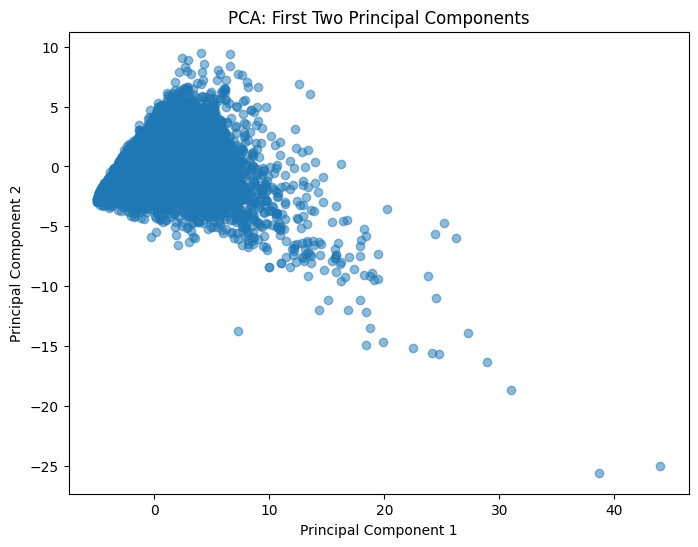

In [5]:
# Scatter plot of first two principal components
plt.figure(figsize=(8,6))
plt.scatter(principal_components_2[:, 0], principal_components_2[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA: First Two Principal Components')
plt.show()

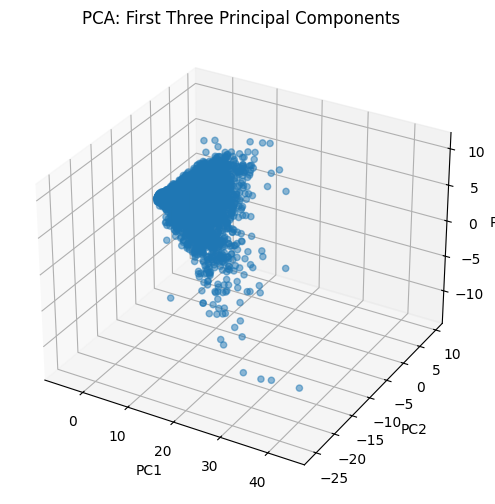

In [6]:
# 3D scatter plot of first three principal components
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(principal_components_3[:, 0], principal_components_3[:, 1], principal_components_3[:, 2], alpha=0.5)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA: First Three Principal Components')
plt.show()

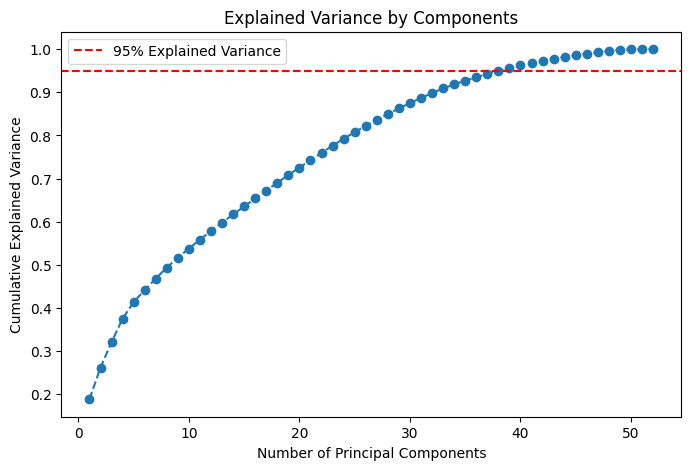

Number of components for 95% explained variance: 39


In [7]:
# Explained variance ratio
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(explained_variance >= 0.95) + 1  # Find components for 95% variance

# Plot cumulative explained variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.legend()
plt.show()

print(f'Number of components for 95% explained variance: {n_components_95}')

In [8]:
pca_95 = PCA(n_components=n_components_95)
pca_95_df = pca_95.fit_transform(data_scaled)
 
pca_95_df.shape

(12952, 39)

In [9]:
# Get eigenvalues from the full PCA
eigenvalues = pca_full.explained_variance_

# Display the top 3 eigenvalues
print("Top 3 eigenvalues:")
for i in range(3):
    print(f"Eigenvalue {i+1}: {eigenvalues[i]:.4f}")

Top 3 eigenvalues:
Eigenvalue 1: 9.7701
Eigenvalue 2: 3.8277
Eigenvalue 3: 3.0569
